In [1]:
using LinearAlgebra, Plots, Random, Distributions, PosDefManifold, CovarianceEstimation

In [2]:
push!(LOAD_PATH, "./src")
using TNLatent

In [3]:
# settings
SZ = [10, 10, 10]  # data shape
FL = prod(SZ)  # feature length
N = 100  # sampler number
push!(SZ, N)
D = length(SZ)
T = Float64
τ = T(1e-3)
SHAPE = "band";  # band, ped, lin_band, lin_ped

In [4]:
# generate data
fun = Symbol(SHAPE)
ΣLatent = @eval $fun(T, FL)
ΣTrue = ΣLatent + τ * I
rng = MersenneTwister(233)
YObs_ = rand(
    rng,
    MvNormal(zeros(T, FL), ΣTrue),
    N
)

YObs = reshape(YObs_, SZ...)
println(size(YObs))

(10, 10, 10, 100)


In [5]:
# benchmark model, the Ledoit-Wolf shrinkage estimator, see CovarianceEstimation.jl
method = LinearShrinkage(ConstantCorrelation())
ΣEst_LW = cov(method, YObs_');

In [6]:
# model
opt = Optim{T}(
    iter = 800,
    init = "randn",
    initScale = 0.1,
    trun = eps(T),
    isPrune = true,
    isPrint = 50,
    ϵ = 1e-10
)
rInit = [1, 20, 20, 20]
@time YEst, _, post = TRLF_EM(YObs, rInit, opt);

┌ Info: EM Algorithm for Multiplicative Gamma Process Tensor Ring Latent Factor Model.
└ @ TNLatent /home/barry/Publish_Code/TR_latent_factor/src/trlf_em.jl:41


Epoch 50: Rank estimate is [1, 4, 10, 20], Change is 0.00047992281402577434.
Epoch 100: Rank estimate is [1, 3, 10, 20], Change is 0.00032531312643296624.
Epoch 150: Rank estimate is [1, 3, 10, 20], Change is 1.1393719335814707e-6.
Epoch 200: Rank estimate is [1, 3, 10, 20], Change is 3.2564562127207116e-5.
Converge in 234 epochs.
 44.015494 seconds (97.96 M allocations: 21.132 GiB, 4.66% gc time)


LED: LW is 70.82091365356648, TTLF is 5.212559303856755.
The true 1 / τ is 1000.0, estimated is 1005.2231849481518.


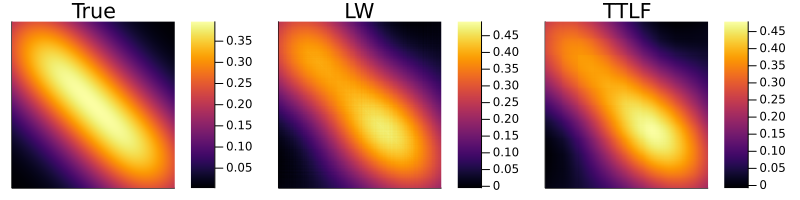

In [8]:
ΣEst = computeΣ(YEst)
ΣEst += 1 / post["τ"] * I
# ΣEst += Diagonal(1 ./ post["τ"])
log_dist_lw = distance(logEuclidean, Hermitian(ΣEst_LW), Hermitian(ΣTrue))
log_dist = distance(logEuclidean, Hermitian(ΣEst), Hermitian(ΣTrue))
println("LED: LW is $log_dist_lw, TTLF is $log_dist.")
println("The true 1 / τ is $(1 / τ), estimated is $(post["τ"]).")

gr(size = (800, 200))
p1 = heatmap(ΣTrue, yflip = true, title = "True")
p2 = heatmap(ΣEst_LW, yflip = true, title = "LW")
p3 = heatmap(ΣEst, yflip = true, title = "TTLF")
plot(p1, p2, p3, axis = nothing, layout = (1, 3))